### FRB Event Rate

Calculate the expected FRB event rate for thew ALFABURST survey based on Lorimer et al. 2013

**Assumptions**

1. Pulse width is approximately 1 ms
2. FRB is a standard candles
3. Thornton et al. 2013 correctly relates flux density to redshift

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [127]:
# Parameters
SEFD = 3. # Jy, SEFD of ALFA (main beam)
threshold = 10. # SNR threshold of detection pipeline
pulseWidth = 5.*1024. # us, expected pulse width
tRes = 256. # us, spectra time resolution
dFactor = pulseWidth / tRes# decimation factor
sMin = SEFD * (threshold / np.sqrt(dFactor)) # Minimum flux density detection, based on radiometer equation

fObsMin = 1347e6 # ALFABURST 56 MHz bandwidth system min frequency
fObsMax = 1403e6 # ALFABURST 56 MHz bandwidth system max frequency

alphas = [-2., -1.4, -0.7, -0.1, 0.1, 0.7] # spectral indicies to model
#zMax = 8.234 # from frb_search_volume.ipynb
zMax = 0.5

print sMin

6.7082039325


In [128]:
def coMovingDist(z):
    """Co-moving distance in Gpc, Eq. 3 from Lorimer et al. 2013
    z: float, redshift
    """
    c = 299792.458 # km s^-1
    H0 = 68. # km s^-1 Mpc^-1
    OmegaM = 0.32
    OmegaLambda = 0.68
    
    integrand = lambda zp: 1. / np.sqrt(OmegaM * ((1. + zp)**3.) + OmegaLambda)
    dd, err = scipy.integrate.quad(integrand, 0., z)
    return ((c/H0) * dd) * 1e-3

def coMovingVol(z):
    """Co-moving volume in Gpc^3
    z: float, redshift"""
    return (4./3.)*(coMovingDist(z)**3.)

def calcLModel(sPeakRef=1., alphaRef=-1.4, zRef=0.75, fLumMin=1e7, fLumMax=1e10, fObsMin=1182e6, fObsMax=1582e6):
    """Calculate the standard candle FRB bolometric luminosity based on Thornton et al. 2013 model, this is used
    to calibrate the flux-redshift relationship
    sPeakRef: float, Jy, peak flux density, Thornton et al.: 1.
    alphaRef: float, spectal index, Thornton et al.: -1.4
    zRef: float, redshift, Thornton et al.: 0.75
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    fObsMin: float, Hz, minimum observing frequency, Thornton et al.: 1186 MHz
    fObsMax: float, Hz, maximum observing frequency, Thornton et al.: 1582 MHz"""
    sPeakRefErgs = sPeakRef * 1e-19 # unit: erg s^-1 ; 1 Jy = 10^-26 W = 10^-19 erg s^-1
    
    dd = coMovingDist(zRef) * 3.086e25 # Convert from Gpc to m

    LL = ((fObsMax-fObsMin)/((fObsMax**(alphaRef+1.))-(fObsMin**(alphaRef+1.)))) * sPeakRefErgs \
            * 4. * np.pi * (dd**2.) \
            * (((fLumMax**(alphaRef+1.))-(fLumMin**(alphaRef+1.)))/((1.+zRef)**(alphaRef-1.)))
    return LL

def calcSpeak(LModel, z, alpha, fObsMin, fObsMax, fLumMin=1e7, fLumMax=1e10):
    """Calculate the peak flux density, Lorimer et al. 2013 eq. 9
    LModel: float, ergs s^-1, bolometric luminosity model output of calcLModel()
    z: float, redshift of source
    alpha: float, spectral index of FRB standard candle model
    fObsMin: float, Hz, minimum observing frequency
    fObsMax: float, Hz, maximum observing frequency
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    """
    dd = coMovingDist(z) * 3.086e25 # Convert from Gpc to m
    
    sPeak = (LModel * ((1. + z)**(alpha-1.))) \
            * (1. / (4. * np.pi * dd**2. * ((fLumMax**(alpha+1.)) - (fLumMin**(alpha+1.)))) ) \
            * (((fObsMax**(alpha+1.)) - (fObsMin**(alpha+1.)))/(fObsMax - fObsMin))

    return sPeak / 1e-19

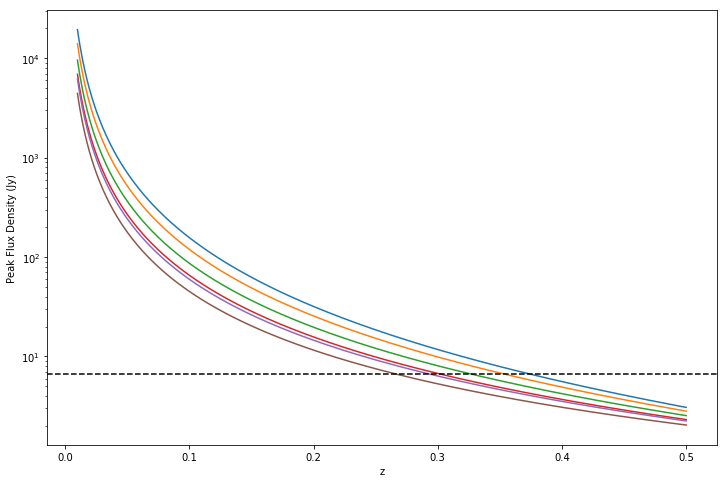

In [129]:
zArr = np.linspace(0.01, zMax, 512)
sPeakArr = np.zeros((len(alphas), len(zArr)))

for aid, alpha in enumerate(alphas):
    LModel = calcLModel(alphaRef=alpha)
    for zid,zz in enumerate(zArr):
        sPeakArr[aid, zid] = calcSpeak(LModel, zz, alpha, fObsMin, fObsMax)
    
    plt.semilogy(zArr, sPeakArr[aid])

plt.axhline(y=sMin, xmin=0.0, xmax=1.0, color="k", linestyle="--")
plt.xlabel('z')
plt.ylabel('Peak Flux Density (Jy)')

In [ ]:
# TODO: different decimation factors
# TODO: plot labels
# Compute rates